In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

In [2]:
cred_trans = pd.read_csv('data/credit_card_transactions-ibm_v2.csv')
cred_trans.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [7]:
cred_trans.shape

(24386900, 21)

In [3]:
cred_trans.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

In [4]:
## Let's remove the white space in the columns and replace them with underscore
cred_trans.columns = [x.replace(" ", "_").replace("?", "") for x in cred_trans.columns]
cred_trans.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use_Chip',
       'Merchant_Name', 'Merchant_City', 'Merchant_State', 'Zip', 'MCC',
       'Errors', 'Is_Fraud'],
      dtype='object')

In [5]:
def feature_eng(df):
    # Extract hour and minute from the 'Time' column
    df['Hour'] = df['Time'].str.split(':').str[0].astype(int)
    df['Minute'] = df['Time'].str.split(':').str[1].astype(int)
    df['Year'] = df['Year'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Day'] = df['Day'].astype(int)

    # Create a datetime object for each date and time
    df['DateTime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

    # Extract the day of the week (0: Monday, 6: Sunday)
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek

    return df


cred_trans = feature_eng(cred_trans.copy())
cred_trans.head()


,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Hour,Minute,DateTime,DayOfWeek
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,6,21,2002-09-01 06:21:00,6
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,6,42,2002-09-01 06:42:00,6
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,6,22,2002-09-02 06:22:00,0
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,17,45,2002-09-02 17:45:00,0
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,6,23,2002-09-03 06:23:00,1


In [6]:
cred_trans.dtypes

User                       int64
Card                       int64
Year                       int32
Month                      int32
Day                        int32
Time                      object
Amount                    object
Use_Chip                  object
Merchant_Name              int64
Merchant_City             object
Merchant_State            object
Zip                      float64
MCC                        int64
Errors                    object
Hour                       int32
Minute                     int32
DateTime          datetime64[ns]
DayOfWeek                  int64
dtype: object

In [6]:
# Create a new feature for the frequency of transactions from each city
cred_trans['City_Transactions'] = cred_trans.groupby('Merchant_City')['Merchant_City'].transform('count')

# Create a new feature for the frequency of transactions from each state
cred_trans['State_Transactions'] = cred_trans.groupby('Merchant_State')['Merchant_State'].transform('count')

# Print the updated DataFrame
print(cred_trans[['Merchant_City', 'City_Transactions', 'Merchant_State', 'State_Transactions']].head())

   Merchant_City  City_Transactions Merchant_State  State_Transactions
0       La Verne              10912             CA           2591830.0
1  Monterey Park               7319             CA           2591830.0
2  Monterey Park               7319             CA           2591830.0
3  Monterey Park               7319             CA           2591830.0
4       La Verne              10912             CA           2591830.0


In [8]:
## Iterating through columns to find out which columns contain nulls via list comprehension
[features for features in cred_trans.columns if cred_trans[features].isnull().sum()>0]
## Three columns have nulls

['Merchant_State', 'Zip', 'Errors', 'State_Transactions']

In [8]:
cred_trans['Is_Fraud'].value_counts()

No     24357143
Yes       29757
Name: Is_Fraud, dtype: int64

In [10]:
cred_trans['Is_Fraud'].value_counts()/len(cred_trans)*100

No     99.87798
Yes     0.12202
Name: Is_Fraud, dtype: float64

In [11]:
fraud_df = cred_trans[cred_trans['Is_Fraud']=='Yes']
non_fraud_df = cred_trans[cred_trans['Is_Fraud']=='No']
non_fraud_df.shape,fraud_df.shape

((24357143, 21), (29757, 21))

In [12]:
## Let's see how many nulls there are in the respective columns
fraud_df.isnull().sum()
## We also have missing values in Errors which essentially means that there were no errors.

User                      0
Card                      0
Year                      0
Month                     0
Day                       0
Time                      0
Amount                    0
Use_Chip                  0
Merchant_Name             0
Merchant_City             0
Merchant_State        18349
Zip                   24852
MCC                       0
Errors                28471
Is_Fraud                  0
Hour                      0
Minute                    0
DateTime                  0
DayOfWeek                 0
City_Transactions         0
State_Transactions    18349
dtype: int64

Range of Years

In [13]:
fraud_df.Year.sort_values().min(),cred_trans.Year.sort_values().max()

(1996, 2020)

In [14]:
## Let's see how many different type of errors there are.
fraud_df['Errors'].value_counts()
## There are 22 different types of errors (excluding the NaNs)

Insufficient Balance                    396
Bad PIN                                 302
Bad CVV                                 280
Bad Expiration                          120
Bad Card Number                         105
Technical Glitch                         63
Bad PIN,Insufficient Balance              7
Bad CVV,Insufficient Balance              4
Bad Expiration,Bad CVV                    2
Bad Expiration,Technical Glitch           2
Bad Card Number,Insufficient Balance      2
Bad Expiration,Insufficient Balance       1
Bad PIN,Technical Glitch                  1
Bad CVV,Technical Glitch                  1
Name: Errors, dtype: int64

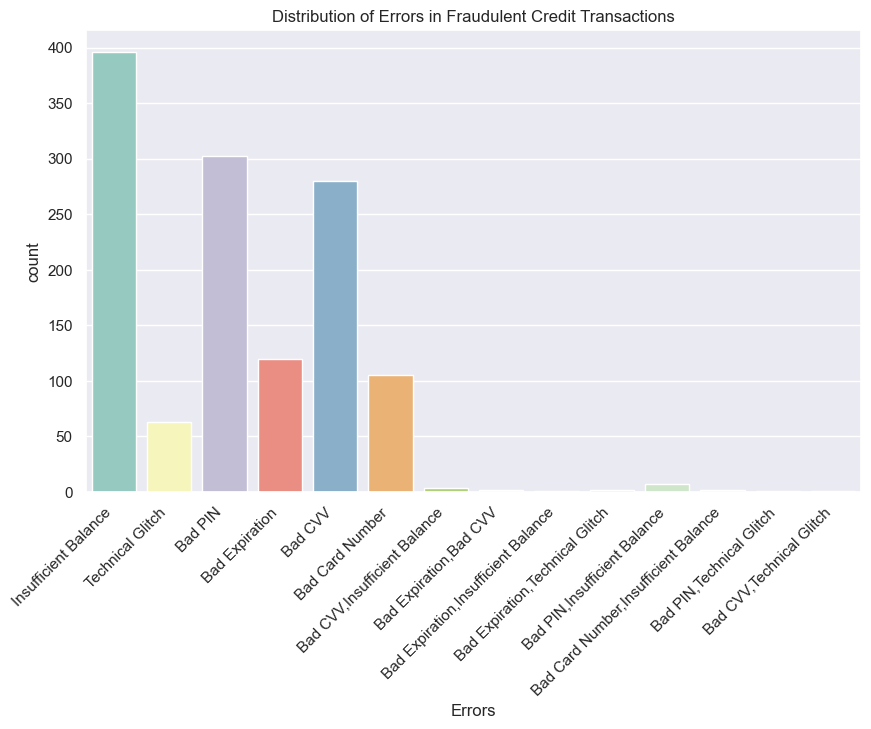

In [26]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="Errors", data=fraud_df, palette="Set3")
plt.title("Distribution of Errors in Fraudulent Credit Transactions")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()


In [16]:
cred_trans.Use_Chip.unique()

## There are 3 different types of transactions being done: 1) Swipe 2) Online 3) Chip
## We could probably map these numerically

array(['Swipe Transaction', 'Online Transaction', 'Chip Transaction'],
      dtype=object)

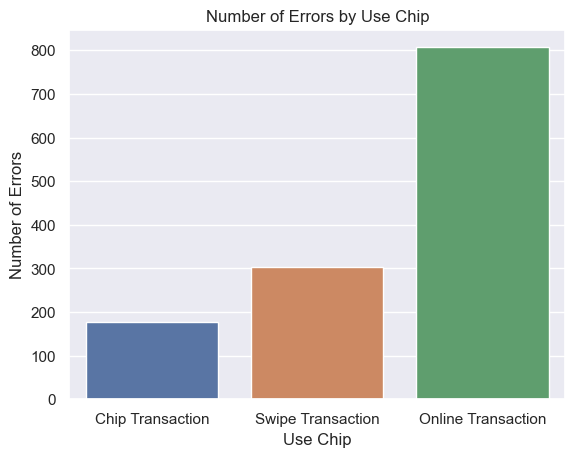

In [17]:
errs_by_chip = fraud_df.groupby('Use_Chip')[['Errors']].count().sort_values('Errors', ascending = True)
sns.barplot(x=errs_by_chip.index, y='Errors', data=errs_by_chip)
plt.title("Number of Errors by Use Chip")
plt.xlabel("Use Chip")
plt.ylabel("Number of Errors")
plt.show()

## **Statistical analysis**

In [18]:
import scipy.stats as stats

def hypothesistesting(df,error_counts):
    

    # Select low occurrence errors based on a threshold (e.g., < 100 occurrences)
    low_occurrence_errors = error_counts[error_counts < 50]

    # Get the majority of errors (with higher occurrence)
    majority_errors = error_counts[error_counts >= 50]

    # Create a contingency table with low occurrence errors and majority errors
    contingency_table = pd.crosstab(index=error_data.isin(low_occurrence_errors.index), columns="Count")

    # Perform chi-square test
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    return chi2, p_value



In [19]:
# Assuming 'df' is your DataFrame containing the error data
error_data = fraud_df['Errors']

# Calculate the frequency of each error type
error_counts = error_data.value_counts()

error_counts

Insufficient Balance                    396
Bad PIN                                 302
Bad CVV                                 280
Bad Expiration                          120
Bad Card Number                         105
Technical Glitch                         63
Bad PIN,Insufficient Balance              7
Bad CVV,Insufficient Balance              4
Bad Expiration,Bad CVV                    2
Bad Expiration,Technical Glitch           2
Bad Card Number,Insufficient Balance      2
Bad Expiration,Insufficient Balance       1
Bad PIN,Technical Glitch                  1
Bad CVV,Technical Glitch                  1
Name: Errors, dtype: int64

In [20]:
chi2, p_value = hypothesistesting(fraud_df,error_counts)

# Print the results
print("Chi-square statistic:", chi2)
print("P-value:", p_value)

Chi-square statistic: 0.0
P-value: 1.0


In [21]:

# Sort the dataset based on 'User', 'Card', and 'DateTime' columns in ascending order
sorted_df = fraud_df.sort_values(['User', 'Card', 'DateTime'], ascending=True)

# Create an empty DataFrame to store consequent transaction attempts
consequent_attempts_df = pd.DataFrame(columns=fraud_df.columns)

# Initialize the previous_row variable
previous_row = None

# Iterate through the sorted dataset
for index, row in sorted_df.iterrows():
    # Check if it's the first row
    if previous_row is None:
        previous_row = row
        continue

    # Check if the current row belongs to the same user and card as the previous row
    if row['User'] == previous_row['User'] and row['Card'] == previous_row['Card']:
        # Calculate the time difference between the current and previous transactions
        time_diff = row['DateTime'] - previous_row['DateTime']

        # Specify a time threshold (e.g., 5 minutes) to consider transactions as consequent attempts
        if time_diff.total_seconds() <= 300:
            # Append the pair of previous_row and current row to the consequent_attempts_df DataFrame
            consequent_attempts_df = consequent_attempts_df.append(previous_row, ignore_index=True)
            consequent_attempts_df = consequent_attempts_df.append(row, ignore_index=True)

    # Update the previous_row variable
    previous_row = row


C:\Users\adity\AppData\Local\Temp\ipykernel_4140\2309639967.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  consequent_attempts_df = consequent_attempts_df.append(previous_row, ignore_index=True)
C:\Users\adity\AppData\Local\Temp\ipykernel_4140\2309639967.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  consequent_attempts_df = consequent_attempts_df.append(row, ignore_index=True)


In [22]:
consequent_attempts_df.shape

(4072, 21)

In [23]:
# Remove duplicate rows from consequent_attempts_df
consequent_attempts_df = consequent_attempts_df.drop_duplicates()
consequent_attempts_df.shape

(4047, 21)

In [24]:
consequent_attempts_df.head(2)

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,...,Zip,MCC,Errors,Is_Fraud,Hour,Minute,DateTime,DayOfWeek,City_Transactions,State_Transactions
0,0,0,2015,11,16,09:41,$50.81,Online Transaction,-551332107213382088,ONLINE,...,NaN,4411,NaN,Yes,9,41,2015-11-16 09:41:00,0,2720821,NaN
1,0,0,2015,11,16,09:46,$248.36,Online Transaction,4872340518840476610,ONLINE,...,NaN,5732,NaN,Yes,9,46,2015-11-16 09:46:00,0,2720821,NaN


Based on the first 2 rows, the consecutive transactions seem to be a ***refund***. 

The first transaction has a positive amount of $59.00, while the second transaction has a negative amount of -$59.00. This pattern suggests that the second transaction is a refund associated with the previous transaction.

In [25]:
type(consequent_attempts[0])

NameError: name 'consequent_attempts' is not defined